# Etude dataset avec NLP : Disaster Tweets

**Context**
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


## Imports & Loading

In [8]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install -U spacy

Note: you may need to restart the kernel to use updated packages.


In [10]:
!python -m spacy download en_core_web_sm

2022-10-26 17:09:34.122653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 17:09:34.313942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-26 17:09:34.313992: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-26 17:09:34.355227: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 17:09:35.259740: W tensorflow/stream_executor/platform/de

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from collections import Counter
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math
import missingno
import warnings 
import spacy
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
import pyLDAvis
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from wordcloud import WordCloud
from textblob import TextBlob
import tensorflow as tf
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')
# Loading model
nlp = spacy.load('en_core_web_sm')

2022-10-26 17:09:45.065035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 17:09:45.280356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-26 17:09:45.280393: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-26 17:09:45.322217: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 17:09:46.416585: W tensorflow/stream_executor/platform/de

In [12]:
# Load datasets

train_df = pd.read_csv("train.csv", encoding = "ISO8859-1")
test_df = pd.read_csv("test.csv", encoding = "ISO8859-1")

In [13]:
pip install unidecode

  Using cached Unidecode-1.3.6-py3-none-any.whl (235 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
from unidecode import unidecode
train_df['text'] = train_df['text'].apply(unidecode)
train_df['keyword'] = [unidecode(x) if x is pd.notnull else x for x in train_df['keyword'] ]

test_df['text'] = test_df['text'].apply(unidecode)
test_df['keyword'] = [unidecode(x) if x is pd.notnull else x for x in test_df['keyword'] ]

## **Preprocessing**

### Drop doublons

In [16]:
train_df = train_df.drop_duplicates(subset = ['text']).reset_index()
test_df = test_df.drop_duplicates(subset = ['text']).reset_index()

### Lower casing

In [17]:
train_df['cleaned']=train_df['text'].apply(lambda x: x.lower())
train_df.head(2)
test_df['cleaned']=test_df['text'].apply(lambda x: x.lower())
test_df.head(2)

,index,id,keyword,location,text,cleaned
0,0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","heard about #earthquake is different cities, s..."


### Remove digits and words containing digits

In [19]:
# Remplace &amp; par &
train_df['cleaned'] = train_df['cleaned'].str.replace('&amp;','')
test_df['cleaned'] = test_df['cleaned'].str.replace('&amp;','')

### Encoding cleaning

### Expanding contractions
Using dictionary of common English contractions

In [23]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "i'd": "i would", "i'd've": "i would have","i'll": "i will",
                     "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have", "they ve": "they have", "they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have",
                     "'ve": " have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
train_df['cleaned']=train_df['cleaned'].apply(lambda x:expand_contractions(x))
train_df.head(2)
test_df['cleaned']=test_df['cleaned'].apply(lambda x:expand_contractions(x))
test_df.head(2)

,index,id,keyword,location,text,cleaned
0,0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","heard about #earthquake is different cities, s..."


In [24]:
# Remove http / https URLs
train_df['cleaned'] = train_df['cleaned'].str.replace(r'http\S+', '', regex=True)
test_df['cleaned'] = test_df['cleaned'].str.replace(r'http\S+', '', regex=True)

In [25]:
train_df['cleaned']=train_df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
train_df.head(2)

,index,id,keyword,location,text,target,cleaned
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada


In [26]:
# SUPP ?


def tweet_cleaner(tweet):
    # Special characters
    tweet = re.sub(r"%20", "", tweet)
    tweet = re.sub(r"%", "", tweet)
    tweet = re.sub(r"'", "", tweet)
    tweet = re.sub(r"\x89û_", "", tweet)
    tweet = re.sub(r"\x89ûò", "", tweet)
    tweet = re.sub(r"re\x89û_", "", tweet)
    tweet = re.sub(r"\x89û", "", tweet)
    tweet = re.sub(r"\x89Û", "", tweet)
    tweet = re.sub(r"re\x89Û", "re ", tweet)
    tweet = re.sub(r"re\x89û", "re ", tweet)
    tweet = re.sub(r"\x89ûª", "'", tweet)
    tweet = re.sub(r"\x89û", "", tweet)
    tweet = re.sub(r"\x89ûò", " ", tweet)
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)  
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    tweet = re.sub(r"â", "", tweet)
    tweet = re.sub(r"ã", "", tweet)
    return tweet

train_df['cleaned'] = train_df['cleaned'].apply(lambda x: tweet_cleaner(x))
test_df['cleaned'] = test_df['cleaned'].apply(lambda x: tweet_cleaner(x))

### Remove Punctuations

In [27]:
train_df['cleaned']=train_df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
train_df['cleaned'] = train_df['cleaned'].apply(lambda x : re.sub(r'  ', ' ', x))
test_df['cleaned'] = test_df['cleaned'].apply(lambda x : re.sub(r'  ', ' ', x))
train_df['cleaned'] = train_df['cleaned'].apply(lambda x : re.sub(r'\n', '', x))
train_df.head(2)

,index,id,keyword,location,text,target,cleaned
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada


## **EDA**

In [28]:
train_df.head()

,index,id,keyword,location,text,target,cleaned
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to ishelter in place are b...
3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


<AxesSubplot:>

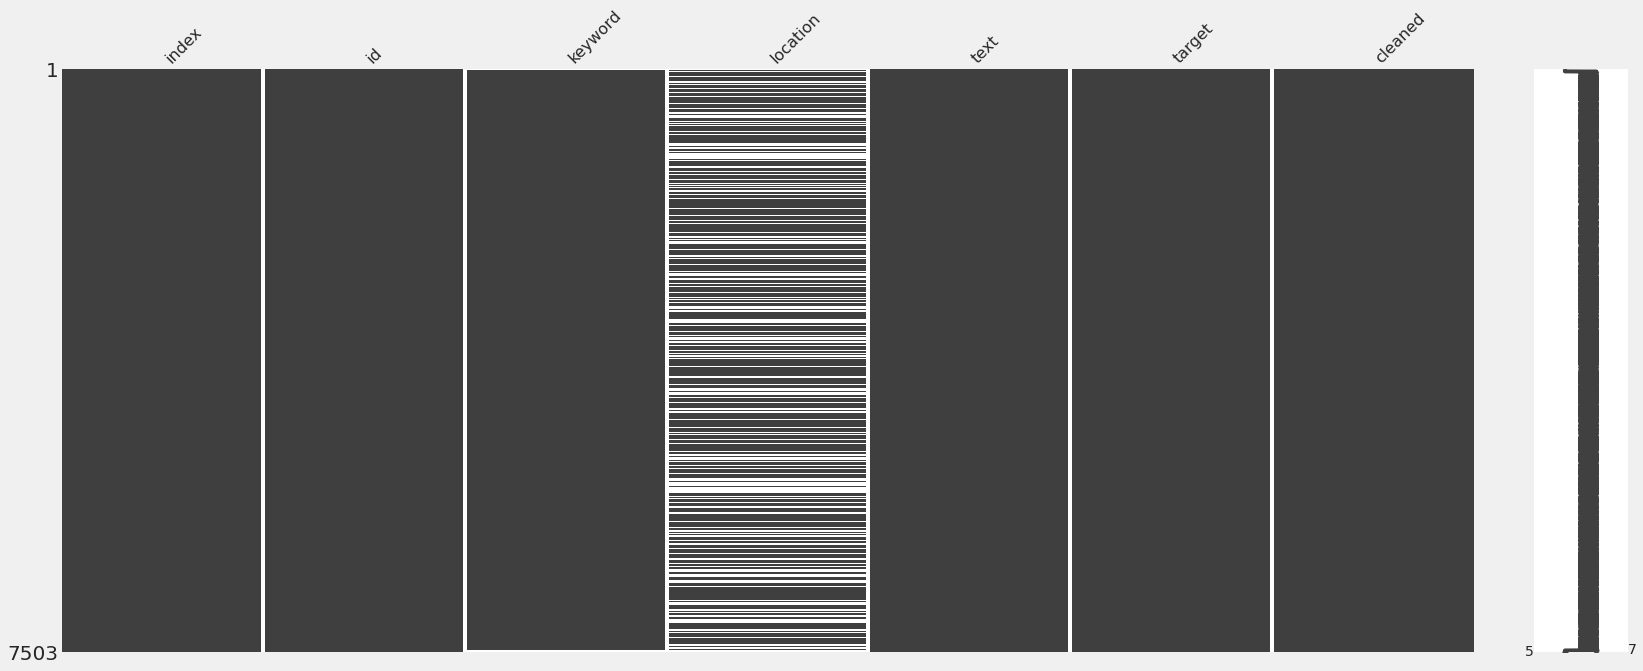

In [29]:
# checking missing data in our dataframe.
missingno.matrix(train_df)

In [30]:
# Get target
target = 'target'

# Get quantitative features and delete the unnccessary features
quantitative = [f for f in train_df.columns if train_df.dtypes[f] != 'object']
quantitative.remove('target')
quantitative.remove('id')

# Get categorical features
categorical = [f for f in train_df.columns if train_df.dtypes[f] == 'object']

,target,id
0,0,4305
1,1,3198


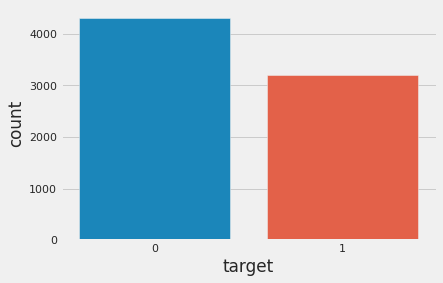

In [31]:
# Now lets see target repartition.
sns.countplot(train_df.target)
train_df.groupby('target').count()['id'].reset_index().sort_values(by='id',ascending=False)



### Number of characters

In [32]:
train_df['charcount'] = train_df['cleaned'].str.len()

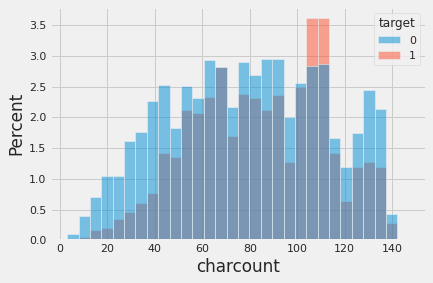

In [33]:
sns.histplot(train_df, x='charcount', stat='percent', hue="target");

### Average word length in sentence

In [34]:
train_df['avgwordlength'] = train_df['cleaned'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x))

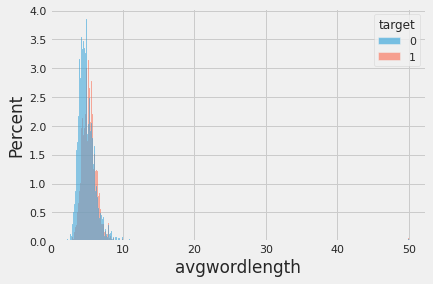

In [35]:
sns.histplot(train_df, x='avgwordlength', stat='percent', hue="target");

### Number of words

In [36]:
train_df['numberofwords'] = train_df['cleaned'].str.split().map(lambda x: len(x))

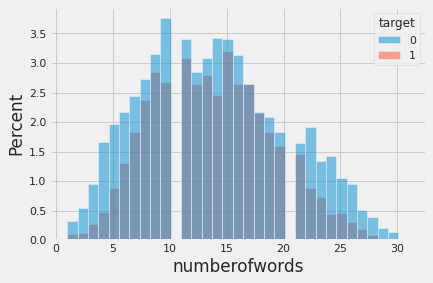

In [37]:
sns.histplot(train_df, x='numberofwords', stat='percent', hue="target");

# AJOUTER LES AUTRES VAR QUANTITATIVES - 

In [38]:
# Clean sans stopwords

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()


tokens = []
lemma = []
pos = []

for doc in nlp.pipe(train_df["cleaned"].astype('unicode').values):
    tokens.append([n.text for n in doc if ((n.lemma not in STOP_WORDS) and (len(n.text) >= 2))])
    lemma.append([n.lemma_ for n in doc if ((n.lemma_ not in STOP_WORDS) and (len(n.lemma_) >= 2))])
for word in tokens:
    for words in word:
        words.strip()
        if len(words) >= 2:
            word.remove(words)
for word in lemma:
    for words in word:
        words.strip()
        if len(words) >= 2:
            word.remove(words)
while("" in tokens):
    tokens.remove("")
while("" in lemma):
    lemma.remove("")
train_df['desc_tokens'] = tokens
train_df['desc_lemma'] = lemma
train_df['desc_lemma_text'] = train_df['desc_lemma'].map(lambda x: " ".join(s for s in x if len(s) >= 2))

### Top n-grams

In [39]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

#### Top bi-grams

Target == 0

<AxesSubplot:>

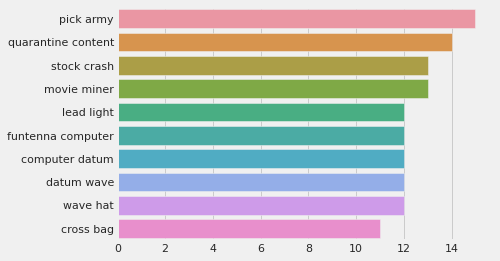

In [40]:
top_n_bigrams=get_top_ngram(train_df[(train_df.target==0)]['desc_lemma_text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x) 

Target == 1

<AxesSubplot:>

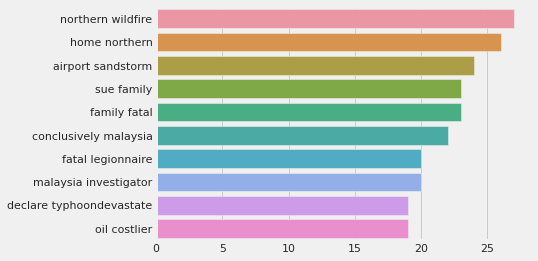

In [41]:
top_n_bigrams=get_top_ngram(train_df[(train_df.target==1)]['desc_lemma_text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x) 

#### Top tri-grams

Target == 0

<AxesSubplot:>

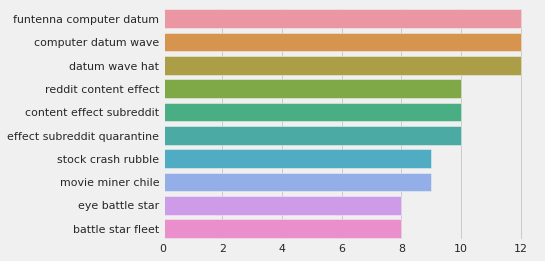

In [42]:
top_tri_grams=get_top_ngram(train_df[(train_df.target==0)]['desc_lemma_text'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

<AxesSubplot:>

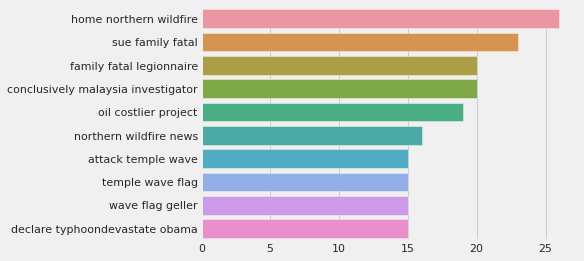

In [43]:
top_tri_grams=get_top_ngram(train_df[(train_df.target==1)]['desc_lemma_text'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

### Wordclouds depending on target value

**Target == 0**

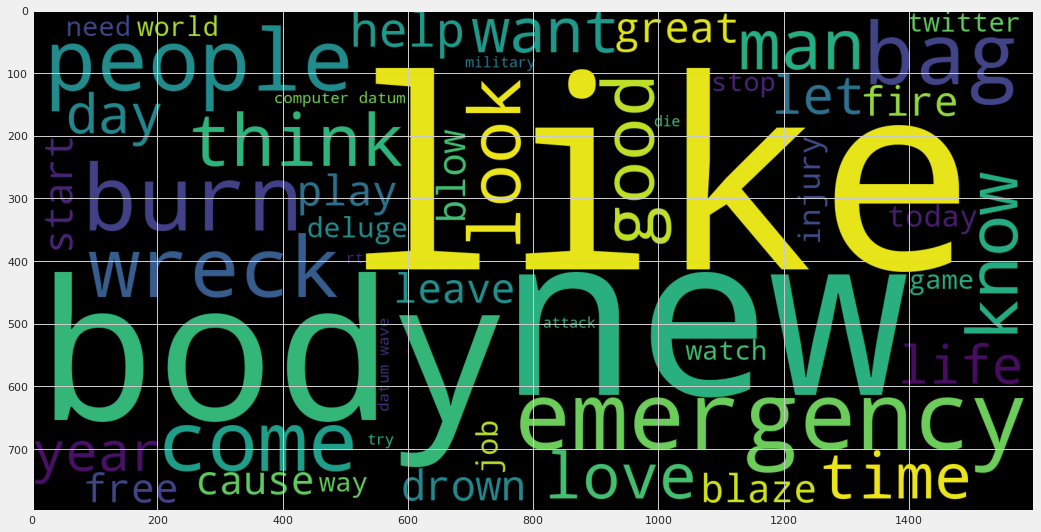

In [44]:
text_merge_clean_token = ''
for j in range(0, len(train_df[train_df['target'] == 0])):
    text_merge_clean_token += str(train_df[train_df['target'] == 0]['desc_lemma_text'].iloc[j])
        
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 50 , width = 1600 , height = 800 , stopwords = STOP_WORDS).generate(text_merge_clean_token)
plt.imshow(wc)


**Target == 1**

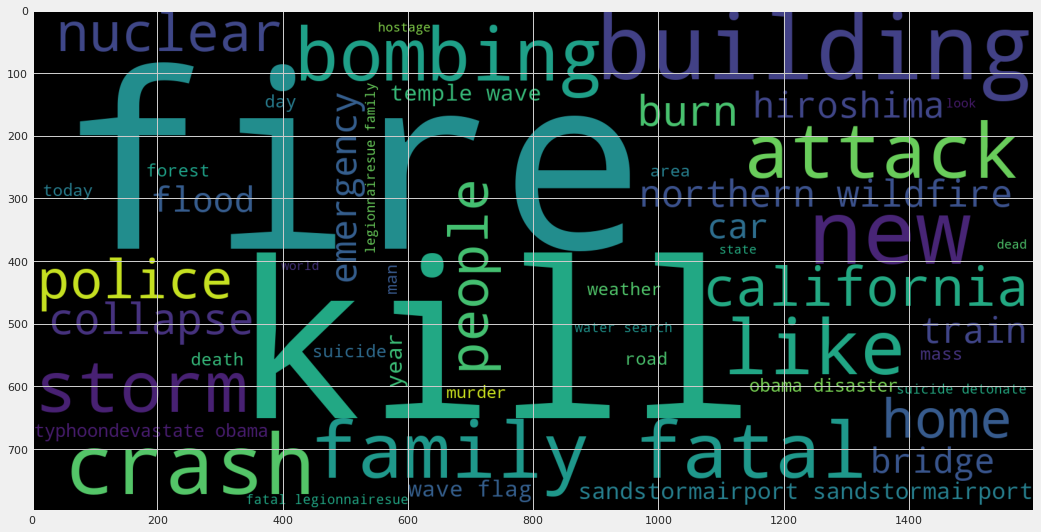

In [48]:
text_merge_clean_token = ''
for j in range(0, len(train_df[train_df['target'] == 1])):
    text_merge_clean_token += str(train_df[train_df['target'] == 1]['desc_lemma_text'].iloc[j])
        
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 50 , width = 1600 , height = 800 , stopwords = STOP_WORDS).generate(text_merge_clean_token)
plt.imshow(wc)


### VADER

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

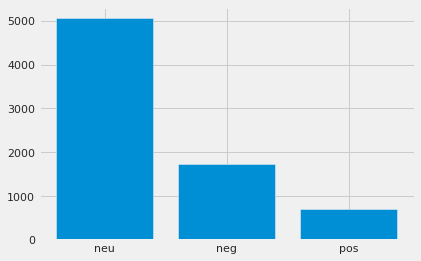

In [50]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

train_df['polarity']=train_df['desc_lemma_text'].\
    map(lambda x: get_vader_score(x))
polarity=train_df['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index,
        polarity.value_counts())

## **Topic modelling**

### Tokenization and lemmatization

In [51]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
import gensim.corpora as corpora # Create Dictionary
id2word = corpora.Dictionary(train_df['desc_lemma'])# Create Corpus
texts = train_df['desc_lemma']# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [53]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [54]:
from pprint import pprint
# Print the Keyword in the 10 topics
print(lda_model.show_topics(num_topics=10, num_words=10))

[(0, '0.041*"wreck" + 0.020*"life" + 0.018*"come" + 0.017*"family" + 0.015*"wave" + 0.013*"water" + 0.012*"terrorism" + 0.010*"august" + 0.009*"coach" + 0.009*"hear"'), (1, '0.049*"like" + 0.018*"northern" + 0.018*"disaster" + 0.016*"year" + 0.015*"nuclear" + 0.013*"live" + 0.013*"fire" + 0.011*"flood" + 0.010*"loud" + 0.010*"terrorist"'), (2, '0.028*"home" + 0.019*"good" + 0.017*"movie" + 0.016*"state" + 0.014*"miner" + 0.012*"upheaval" + 0.011*"face" + 0.011*"miss" + 0.010*"run" + 0.010*"tornado"'), (3, '0.020*"malaysia" + 0.018*"quarantine" + 0.017*"look" + 0.016*"conclusively" + 0.014*"investigator" + 0.014*"sink" + 0.012*"help" + 0.012*"content" + 0.012*"stock" + 0.011*"mass"'), (4, '0.022*"time" + 0.019*"cause" + 0.016*"love" + 0.014*"officer" + 0.012*"airport" + 0.012*"survivor" + 0.012*"smoke" + 0.012*"sandstorm" + 0.011*"man" + 0.011*"oil"'), (5, '0.029*"kill" + 0.026*"wound" + 0.017*"video" + 0.016*"survive" + 0.016*"bombing" + 0.014*"today" + 0.010*"injury" + 0.009*"evacuate

In [55]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6291 samples in 0.049s...
[t-SNE] Computed neighbors for 6291 samples in 0.573s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6291
[t-SNE] Computed conditional probabilities for sample 2000 / 6291
[t-SNE] Computed conditional probabilities for sample 3000 / 6291
[t-SNE] Computed conditional probabilities for sample 4000 / 6291
[t-SNE] Computed conditional probabilities for sample 5000 / 6291
[t-SNE] Computed conditional probabilities for sample 6000 / 6291
[t-SNE] Computed conditional probabilities for sample 6291 / 6291
[t-SNE] Mean sigma: 0.000023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.227074
[t-SNE] KL divergence after 1000 iterations: 0.588694


Loading BokehJS ...

In [56]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [57]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='mmds') # essayer avec mmds
vis

/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.157456  0.300172       1        1  11.778309
1      0.128350 -0.323712       2        1  11.753599
3      0.156935  0.338650       3        1  10.953212
5     -0.185960 -0.287317       4        1  10.039233
4     -0.271088  0.116018       5        1   9.959845
9      0.110406  0.163584       6        1   9.390072
6      0.328005 -0.101060       7        1   9.214724
0     -0.287591 -0.078540       8        1   9.152267
8      0.203881  0.000300       9        1   9.054699
2     -0.025482 -0.128096      10        1   8.704040, topic_info=         Term        Freq       Total Category  logprob  loglift
574      like  161.000000  161.000000  Default  30.0000  30.0000
343     wreck  105.000000  105.000000  Default  29.0000  29.0000
316      news   89.000000   89.000000  Default  28.0000  28.0000
235      kill   81.000000   81.000000  Default  27.0000  27.0000
616     storm   76.000000   76.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
664     point   12.177099   12.910086  Topic10  -5.3011   2.3829
1139  deliver   11.418051   12.150988  Topic10  -5.3655   2.3792
96        man   15.103656   47.443061  Topic10  -5.0857   1.2968
2        fire   17.520176  109.846993  Topic10  -4.9373   0.6056
773    attack   13.615548   44.605563  Topic10  -5.1894   1.2547

[360 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
74        4  0.977981          
117       3  0.991539        aa
144       1  0.096402  accident
144       8  0.867618  accident
369       5  0.981719   airport
...     ...       ...       ...
343       8  0.992668     wreck
5841      3  0.963402  wreckage
94        2  0.978627      year
607       1  0.984496   youtube
3228      8  0.971292      zone

[354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 4, 6, 5, 10, 7, 1, 9, 3])

### Tokenization

In [61]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer.fit_on_texts(train_df["desc_lemma"])
vocab_length = len(tokenizer.word_index) + 1
train_df["tweet_encoded"] = tokenizer.texts_to_sequences(train_df["desc_lemma"])

In [62]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
def embed(corpus): 
    return tokenizer.texts_to_sequences(corpus)

In [63]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [64]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [65]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
longest_train = max(train_df['cleaned'], key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(
    embed(train_df['cleaned']),
    length_long_sentence,
    padding='post')
test_sentences = pad_sequences(
    embed(test_df['cleaned']), 
    length_long_sentence,
    padding='post')

In [66]:
full_ds = tf.data.Dataset.from_tensor_slices((padded_sentences, train_df['target']))

2022-10-26 17:14:03.558218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [67]:
# Train Test Split
TAKE_SIZE = int(0.7*train_df.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [68]:
 # Regardons un batch 
for tweet, target in train_data.take(1):
    print(tweet, target)

tf.Tensor(
[[  0   0   0 ...   0   0   0]
 [942  45  76 ...   0   0   0]
 [ 83 313   0 ...   0   0   0]
 ...
 [688  24 530 ...   0   0   0]
 [455 890 359 ...   0   0   0]
 [283 100   0 ...   0   0   0]], shape=(64, 31), dtype=int32) tf.Tensor(
[0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1
 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0], shape=(64,), dtype=int64)


In [69]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(min_delta=0.001,patience=10)

Simple model

In [70]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length,16,input_length = length_long_sentence),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 16)            132496    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 132,605
Trainable params: 132,605
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=20, 
                    validation_data=test_data,
                    callbacks=[early_stopping])

Epoch 1/20
83/83 [==============================] - 2s 8ms/step - loss: 0.6828 - accuracy: 0.5784 - val_loss: 0.6819 - val_accuracy: 0.5629
Epoch 2/20
83/83 [==============================] - 0s 6ms/step - loss: 0.6750 - accuracy: 0.5784 - val_loss: 0.6788 - val_accuracy: 0.5629
Epoch 3/20
83/83 [==============================] - 1s 6ms/step - loss: 0.6681 - accuracy: 0.5784 - val_loss: 0.6726 - val_accuracy: 0.5629
Epoch 4/20
83/83 [==============================] - 0s 5ms/step - loss: 0.6558 - accuracy: 0.5863 - val_loss: 0.6600 - val_accuracy: 0.5722
Epoch 5/20
83/83 [==============================] - 1s 6ms/step - loss: 0.6306 - accuracy: 0.6308 - val_loss: 0.6376 - val_accuracy: 0.6548
Epoch 6/20
83/83 [==============================] - 0s 5ms/step - loss: 0.5943 - accuracy: 0.7144 - val_loss: 0.6095 - val_accuracy: 0.6961
Epoch 7/20
83/83 [==============================] - 0s 5ms/step - loss: 0.5547 - accuracy: 0.7610 - val_loss: 0.5846 - val_accuracy: 0.7490
Epoch 8/20
83/83 [==

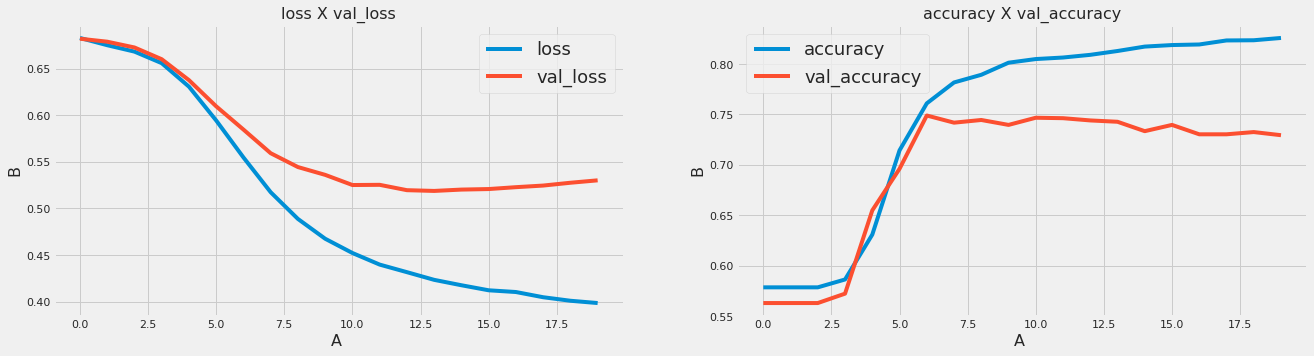

In [72]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

2nd model

In [73]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_length,16,input_length = length_long_sentence))
model.add(tf.keras.layers.LSTM(128,activation='relu',return_sequences=True))
model.add(tf.keras.layers.GlobalAveragePooling1D(),)
model.add(tf.keras.layers.Dense(6, activation = "relu"))
model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))
model.add(tf.keras.layers.Dense(1,activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 16)            132496    
                                                                 
 lstm (LSTM)                 (None, 31, 128)           74240     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                      

Complex model

In [74]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length,16,input_length=length_long_sentence),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(18,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(9,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1,activation='sigmoid')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 31, 16)            132496    
                                                                 
 bidirectional (Bidirectiona  (None, 31, 32)           4224      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 18)                594       
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 batch_normalization (BatchN  (None, 18)              

In [75]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=20, 
                    validation_data=test_data,
                    callbacks=[early_stopping])

Epoch 1/20
83/83 [==============================] - 15s 75ms/step - loss: 0.7530 - accuracy: 0.5149 - val_loss: 0.6852 - val_accuracy: 0.5629
Epoch 2/20
83/83 [==============================] - 4s 52ms/step - loss: 0.6431 - accuracy: 0.6519 - val_loss: 0.6850 - val_accuracy: 0.5629
Epoch 3/20
83/83 [==============================] - 5s 54ms/step - loss: 0.5420 - accuracy: 0.7353 - val_loss: 0.6579 - val_accuracy: 0.5682
Epoch 4/20
83/83 [==============================] - 5s 56ms/step - loss: 0.4963 - accuracy: 0.7782 - val_loss: 0.6358 - val_accuracy: 0.6690
Epoch 5/20
83/83 [==============================] - 5s 54ms/step - loss: 0.4789 - accuracy: 0.7961 - val_loss: 0.6010 - val_accuracy: 0.7041
Epoch 6/20
83/83 [==============================] - 4s 53ms/step - loss: 0.4602 - accuracy: 0.8098 - val_loss: 0.5707 - val_accuracy: 0.6895
Epoch 7/20
83/83 [==============================] - 5s 56ms/step - loss: 0.4498 - accuracy: 0.8126 - val_loss: 0.5782 - val_accuracy: 0.6944
Epoch 8/20
8

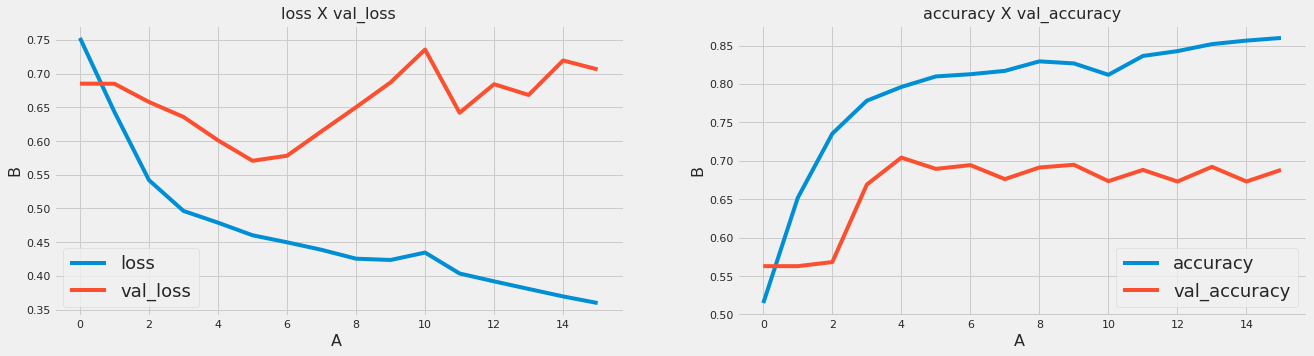

In [76]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])